In [3]:
# include necessary packages
from __future__ import print_function
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

In [4]:
# load your solutions
from p2 import *

ImportError: No module named p2

## Question 1

Write a python function to find the edge locations of a given gray image, and threshold the edge image so that only strong edges are left.

For this you may either use the squared-gradient operator or the Laplacian. Since the Laplacian requires you to find zero-crossings in the image, you may choose to use the square gradient operator. The convolution masks proposed by Sobel should work reasonably well. Else, try your favorite masks. Then please threshold the edge image so that you are left with only strong edges.

```
def find_edge(gray_in, threshold):
    # TODO
    return thresholded_edge_img
```

Input:
* gray_in: a numpy array, of size (H,W), type np.uint8 and range 0~255
* threshold: the number you choose to keep strong edges

Output:
* return a numpy array thresholded_edge_img, with the same format as the input gray_in, and its value is 255 for strong edge and 0 otherwise

Written:
* Briefly explain how you implement the edge detection

Scores: 2

In [11]:
from scipy import signal
## Finds edge of a grayscale image with threshold.
def find_edge(gray_in, threshold):
    image_in = np.copy(gray_in)
    
    ## Using a sobel 3x3 filter
    g_X = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
    g_Y = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])
    dx = signal.convolve2d(image_in, g_X, boundary='symm', mode='same')
    dy = signal.convolve2d(image_in, g_Y, boundary='symm', mode='same')
    
    ## Combine the gradient magnitude output
    thresholded_edge_img = np.zeros(image_in.shape)
    for row in range(0, image_in.shape[0]):
        for column in range(0, image_in.shape[1]):
            a = dx[row][column]**2
            b = dy[row][column]**2
            thresholded_edge_img[row][column] = math.sqrt(a+b)
    ## Final Thresholding
    thresholded_edge_img[np.where(gray_in < threshold)] = 0
    return thresholded_edge_img

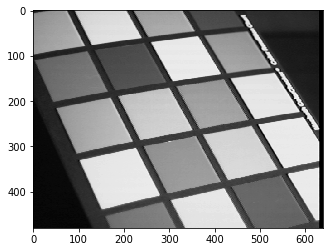

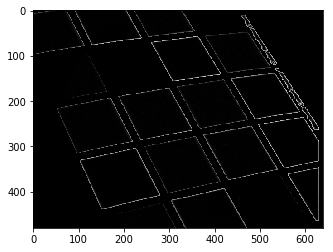

In [12]:
# Verify
gray_img = cv2.imread('hough_simple_1.pgm', cv2.IMREAD_GRAYSCALE)
plt.imshow(gray_img, cmap='gray')
plt.show()
edge_img = find_edge(gray_img, 100)
plt.imshow(edge_img, cmap='gray')
plt.show()

## Question 2

Write a python function to implement the Hough Transform for line detection. Return the accumulator array.

The resolution of the accumulator array must be selected carefully. Low resolution will not give you sufficient accuracy in the estimated parameters, but very high resolution will increase computations and reduce the number of votes in each bin. If you get bad results, you may want to vote for small patches rather than points in the accumulator array. Note that because the number of votes might exceed 255, you should create a new 2d array and store the votes in this array. Once you’re done voting, copy over the values into an output image, scaling values so that they lie between 0 and 255.

```
def hough(edge_in, theta_nbin, rho_nbin):
    # TODO
    return hough_res
```

Inputs:
* edge_in: the result from Question 1, i.e., a numpy array, of size (H,W), type np.uint8 and its value is 255 for strong edge and 0 otherwise.
* theta_nbin: a integer, the number of theta bins
* rho_nbin: a integer, the number of rho bins

Outputs:
* return a numpy array hough_res (the accumulator array), with the size (rho_nbin, theta_nbin), type np.uint8 and range 0~255

Written:
* What is the range of theta?
* What is the range of rho?
* How the resolution affects the speed?

Scores: 4

In [28]:
##
def hough(edge_in, theta_nbin, rho_nbin):
    ## rho value is diagonal of the image, with theta between
    ## -pi/2 and pi/2
    edge_in[np.where(edge_in < 100)] = 0
    rhoMaxVal = math.sqrt((edge_in.shape[0]**2)+ (edge_in.shape[1]**2))
    
    ## Create an accumulator array with res. rhobin*thetabin
    acc = np.zeros((rho_nbin, theta_nbin))
    for row in range(0, edge_in.shape[0]):
        for column in range(0, edge_in.shape[1]):
            if edge_in[row][column] != 0:
                accumulator(column, row, rhoMaxVal, acc)
    ## Scale Hough image
    accMax = np.amax(acc)
    hough_res = acc / accMax * 255
    return hough_res

## Increment counter in the accumulator array w/size thetabin and rhobin
def accumulator(column, row, rhoMaxVal, acc):
    rowNum = acc.shape[0]
    columnNum = acc.shape[1]
    for k in range(0, columnNum):
        theta = (math.pi/(columnNum-1)) * k - (math.pi/2)
        rho = -(column*math.sin(theta) - row*math.cos(theta))
        j = int(math.floor((rho + rhoMaxVal) * ((rowNum - 1)/(2*rhoMaxVal))))
        acc[j][k]+=1

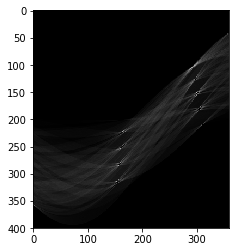

In [29]:
# Verify
hough_res = hough(edge_img, 360, 400)
plt.imshow(hough_res, cmap='gray')
plt.show()

## Question 3

Write a python function to find the strong edges with high votes in the accumulator array, and plot it over the original gray image.

Scan through the accumulator array looking for parameter values that have higher votes than threshold. After having detected the line parameters that have high confidence, paint the detected lines on a copy of the original scene image (using the `cv2.line` function in OpenCV). Make sure that you draw the line using a color that is clearly visible in the output image.

```
def hough_line(gray_in, accumulator_array, hough_threshold):
    # TODO
    return grey_out_with_edge
```

Inputs:
* gray_in: a numpy array, of size (H,W), type np.uint8 and range 0~255. This is actually the same input we used in the Question 1.
* accumulator_array: a numpy array, which is the output of Question 2
* hough_threshold: a threshold to determine high confidence votes

Outputs:
* return a numpy array grey_out_with_edge, of size (H,W,3), type np.uint8 and range 0~255. This is the result image we draw those edge lines on gray_in.

Written:
* How does the resolution of accumulator array affect the edge detection quality?
* How do you draw a line given a line parameter from the accumulator array?

Scores: 4

In [72]:
## hough_line uses accumulator array and hough threshold
## to find the strongest lines and draw them accordingly on
## image "gray_in".
def hough_line(gray_in, accumulator_array, hough_threshold):
    ## Threshold the accumulator array in order to obtain strong lines
    accumulator_array[np.where(accumulator_array < hough_threshold)] = 0
    ## Create output image
    grey_out_with_edge = np.uint8(gray_in)
    grey_out_with_edge = cv2.cvtColor(grey_out_with_edge, cv2.COLOR_GRAY2RGB)
    ## Draw the lines
    rhoMaxVal = math.sqrt((gray_in.shape[0]**2)+(gray_in.shape[1]**2))
    rowNum = accumulator_array.shape[0]
    columnNum = accumulator_array.shape[1]
    imageRowVal = gray_in.shape[0]
    imageColumnVal = gray_in.shape[1]
    for row in range(0, rowNum):
        for column in range(0, columnNum):
            if accumulator_array[row][column] != 0:
                # Calculate values of theta and rho
                rho = ((2*rhoMaxVal)/(rowNum-1))*row-rhoMaxVal
                theta = (math.pi/(columnNum-1))*column-math.pi/2
                # Calculate(x, y) coordinates to obtain line to plot
                # with from xsin(theta)-ycos(theta)+rho = 0
                # which equals y = (sin(theta)/cos(theta))*x+rho/cos(theta)
                slope = math.sin(theta)/math.cos(theta)
                yIntercept = rho/math.cos(theta)
                xLeft = 0
                yLeft = int(yIntercept)
                yTop = 0
                xTop = int((yTop - yIntercept)/slope)
                xRight = imageColumnVal
                yRight = int(slope * xRight + yIntercept)
                yBottom = imageRowVal
                xBottom = int((yBottom - yIntercept)/ slope)
                # Plot values accordingly
                if min(abs(yLeft),abs(xTop)) == yLeft:
                    xAlpha = xLeft
                    yAlpha = yLeft
                else:
                    xAlpha = xTop
                    yAlpha = yTop
                if min(abs(yRight),abs(xBottom)) == yRight:
                    xBeta = xRight
                    yBeta = yRight
                else:
                    xBeta = xBottom
                    yBeta = yBottom
                # Plot line chosen
                cv2.line(grey_out_with_edge, (xAlpha, yAlpha), (xBeta, yBeta), (255, 0, 0), 1)
    return grey_out_with_edge

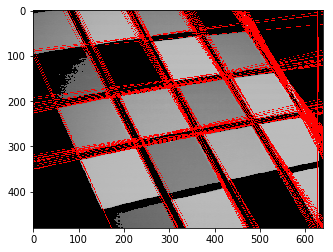

In [73]:
# Verify
plt.imshow(hough_line(gray_img, hough_res, 100))
plt.show()

## Re-run the detection pipeline for other two images

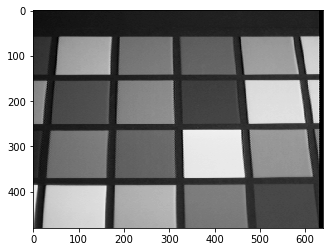

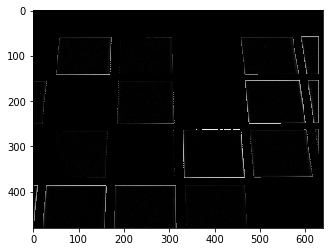

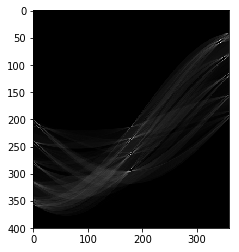

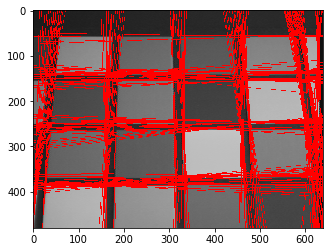

In [76]:
# Q1
gray_img = cv2.imread('hough_simple_2.pgm', cv2.IMREAD_GRAYSCALE)
plt.imshow(gray_img, cmap='gray')
plt.show()
edge_img = find_edge(gray_img, 100)
plt.imshow(edge_img, cmap='gray')
plt.show()

# Q2
hough_res = hough(edge_img, 360, 400)
plt.imshow(hough_res, cmap='gray')
plt.show()

# Q3
plt.imshow(hough_line(gray_img, hough_res, 80))
plt.show()

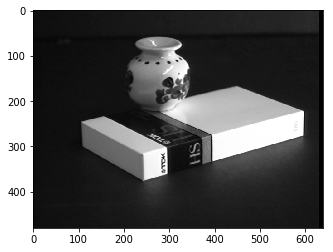

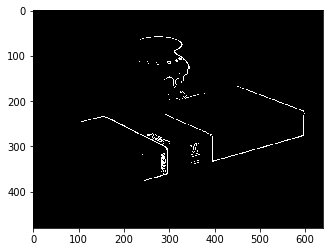

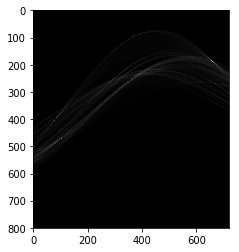

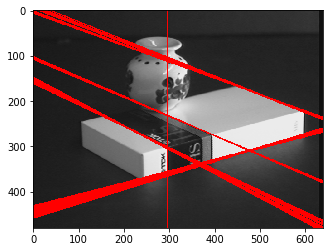

In [7]:
# Q1
gray_img = cv2.imread('hough_complex_1.pgm', cv2.IMREAD_GRAYSCALE)
plt.imshow(gray_img, cmap='gray')
plt.show()
edge_img = find_edge(gray_img, 100)
plt.imshow(edge_img, cmap='gray')
plt.show()

# Q2
hough_res = hough(edge_img, 720, 800)
plt.imshow(hough_res, cmap='gray')
plt.show()

# Q3
plt.imshow(hough_line(gray_img, hough_res, 100))
plt.show()

## Question 4 (Required for Graduate Students)

For a single edge of the original image, does your detector generate a bunch of nearby lines? (see the example below)
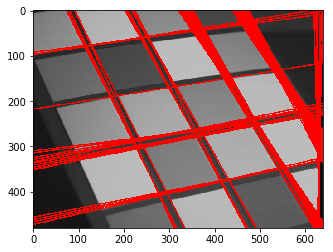

If not, how does your detector avoid that?  
If yes, how can you manage to reduce them? (It can be mitigated if we increase the hough_threshold used in Question 3, but we may miss some edges due to the high threshold)

```
def clean_hough_edge_detection(gray_in):
    # TODO
    return clean_hough_edge_res
```

Inputs:
* gray_in: the input we used in Question 1
* please define all other parameters (e.g. hough_threshold, theta_nbin) inside your clean_hough_edge_detection

Outputs:
* return a numpy array, which is same as the output we requested in Question 3

Written:
Briefly describe how you eliminate those redundant edges, and the parameters you used.

Hint: what we expected is:
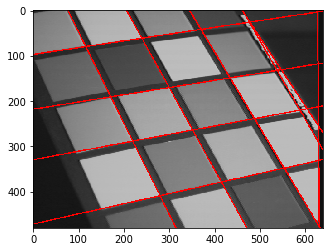

Scores: 6

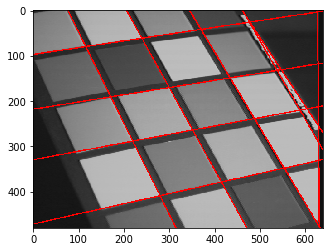

In [8]:
# Verify
plt.imshow(clean_hough_edge_detection(cv2.imread('hough_simple_1.pgm', cv2.IMREAD_GRAYSCALE)))
plt.show()